In [1]:
%pylab inline
import numpy as np
import pylab as pb
import GPy

Populating the interactive namespace from numpy and matplotlib


## Multioutput GP's and Hierarchical modelling

This notebook shows an example with synthethic data of a multioutput GP combined with hierarchical modelling(http://www.biomedcentral.com/1471-2105/14/252)

### Creating Syntethic Data with ICM of GPy

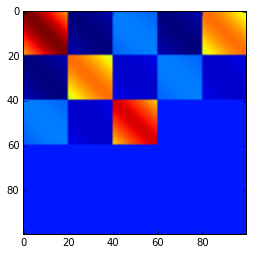

In [2]:
d = 3
time_stamps = 20
kg = GPy.kern.Matern32(1, variance=1., lengthscale=10.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
kf = GPy.kern.Matern32(1, variance=.01, lengthscale=2.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)

x_parent = np.linspace(0, 2*np.pi, time_stamps)
inp = x_parent[:, None]
T = np.r_[np.c_[inp, np.zeros_like(inp)]]
for i in range(1,5):
    T = np.r_[T, np.c_[inp, np.ones_like(inp)*i]]

#print T
C_parent_gen = kg.K(T, None)
plt.imshow(C_parent_gen)

(50,) (50,)


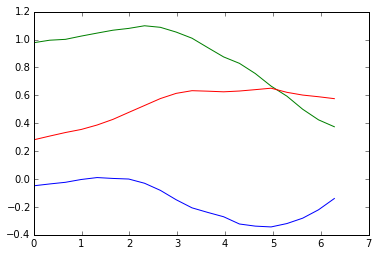

In [59]:
g_mean = np.zeros(T.shape[0])
g_n = np.random.multivariate_normal(g_mean, C_parent_gen, 1)
divs = np.linspace(0,d*time_stamps, d + 1)
print T[0:50,0].shape, g_n[0, 0:50].shape
for i in range(0, divs.shape[0] - 1):
    a = divs[i]
    b = divs[i+1]
    pb.plot(T[a:b,0], g_n[0,a:b])

In [60]:
n_sons = 20
fn_list = []
C_sons_gen = kf.K(T, None)
g_n = g_n.squeeze()
plt.figure(1, figsize=(8,2))
for i in range(0,n_sons):
    f_n = np.random.multivariate_normal(g_n, C_sons_gen, 1)
    f_n = np.squeeze(f_n)
    fn_list.append(f_n)
    #pb.subplot(n_sons/3, 3, i)
    for j in range(0, divs.shape[0] - 1):
        a = divs[j]
        b = divs[j+1]
        #pb.plot(T[a:b,0], f_n[a:b])

### Aranging the data to the Hierarchical GP with ICM

The data is aranged in a way that the first column are the input time points, the second column are the indexes of each output, and the third column contains the index of the replicate

In [74]:
T_hat = np.c_[T, np.zeros_like(T[:,1])]
Y_hat = np.r_[np.c_[fn_list[0]]]
for i in range(1,n_sons):
    T_hat = np.r_[T_hat, np.c_[T, np.ones_like(T[:,1])*i]]
    Y_hat = np.r_[Y_hat, np.c_[fn_list[i]]]

#tmp = np.copy(T_hat[:,2])
#T_hat[:,2] = T_hat[:,1]
#T_hat[:,1] = tmp
#print Y_hat
k1 = GPy.kern.Matern32(1, variance=5., lengthscale=20.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
k2 = GPy.kern.Matern32(1, variance=2., lengthscale=5.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
kernels = [k1,k2] 
HGP = GPy.kern._src.independent_outputs.Hierarchical(kernels)

In [75]:
model = GPy.models.GPRegression(T_hat, Y_hat, HGP) # Making a normal regression
#model.likelihood.variance = 0.01
model.optimize('bfgs')#, messages=1)

In [76]:
model.optimize_restarts(num_restarts = 50)

Optimization restart 1/50, f = -3097.98832467
Optimization restart 2/50, f = -3097.99039783
Optimization restart 3/50, f = -3097.97484106
Optimization restart 4/50, f = -3097.99026554
Optimization restart 5/50, f = -3097.99033258
Optimization restart 6/50, f = -3097.99038618
Optimization restart 7/50, f = -3097.99016244
Optimization restart 8/50, f = -3097.99032368
Optimization restart 9/50, f = -3097.99036992
Optimization restart 10/50, f = -3097.99037965
Optimization restart 11/50, f = -3097.99036289
Optimization restart 12/50, f = -3097.98996331
Optimization restart 13/50, f = -3097.99034166
Optimization restart 14/50, f = -3097.99015909
Optimization restart 15/50, f = -3097.99035276
Optimization restart 16/50, f = -3097.98318414
Optimization restart 17/50, f = -3097.99012391
Optimization restart 18/50, f = -3097.99035403
Optimization restart 19/50, f = -3097.99024769
Optimization restart 20/50, f = -3097.99038774
Optimization restart 21/50, f = -3097.99024521
Optimization restart 2

In [77]:
print kg
print k1
print k1.coregion.W
print kg.coregion.W

  mul.               |  Value   |  Constraint  |  Prior  |  Tied to
  Mat32.variance     |     1.0  |     +ve      |         |         
  Mat32.lengthscale  |    10.0  |     +ve      |         |         
  coregion.W         |  (3, 3)  |              |         |         
  coregion.kappa     |    (3,)  |     +ve      |         |         
  mul_1.             |      Value       |  Constraint  |  Prior  |  Tied to
  Mat32.variance     |  0.106600280613  |     +ve      |         |         
  Mat32.lengthscale  |   8.13598432363  |     +ve      |         |         
  coregion.W         |          (3, 3)  |              |         |         
  coregion.kappa     |            (3,)  |     +ve      |         |         
  Index  |  GP_regression.hierarchy.mul_1.coregion.W  |  Constraint  |   Prior   |  Tied to
  [0 0]  |                                -1.0440785  |              |           |    N/A    
  [0 1]  |                               -0.54231581  |              |           |    N/A    


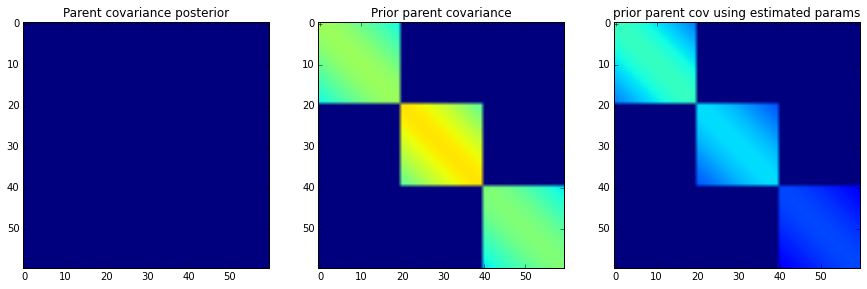

In [78]:
#print T
mu,mvar = model.predict(T, kern=k1, full_cov=True)
C_prior_parent = k1.K(T, None)

plt.figure(1, figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(mvar, vmin=0, vmax=1)
plt.title('Parent covariance posterior')

plt.subplot(1,3,2)
plt.imshow(C_parent_gen, vmin=0, vmax=1)
plt.title('Prior parent covariance' )

plt.subplot(1,3,3)
plt.imshow(C_prior_parent, vmin=0, vmax=1)
plt.title('prior parent cov using estimated params')


Comparison of coregionalization matrices:

(3, 3)


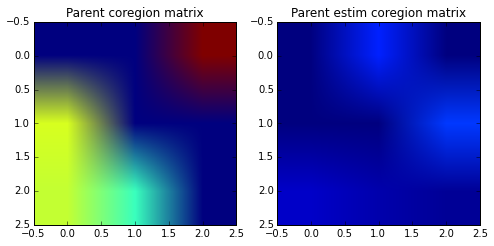

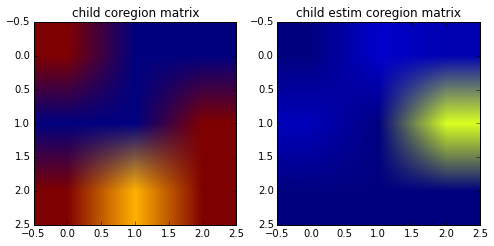

In [79]:
print k1.coregion.W.shape
plt.figure(1, figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(k1.coregion.W, vmin=0, vmax=1)
plt.title('Parent coregion matrix')

plt.subplot(1,2,2)
plt.imshow(kg.coregion.W, vmin=0, vmax=1)
plt.title('Parent estim coregion matrix' )

plt.figure(2, figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(k2.coregion.W, vmin=0, vmax=1)
plt.title('child coregion matrix')

plt.subplot(1,2,2)
plt.imshow(kf.coregion.W, vmin=0, vmax=1)
plt.title('child estim coregion matrix' )

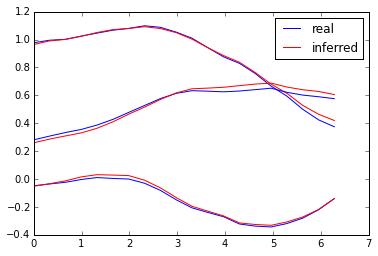

In [80]:
for i in range(0, divs.shape[0] - 1):
    a = divs[i]
    b = divs[i+1]
    blue_line, = pb.plot(T[a:b,0], g_n[a:b], 'b-')
    red_line, = pb.plot(T[a:b,0], mu[a:b], 'r-')
    plt.legend([blue_line, (blue_line, red_line)], ["real", "inferred"])